# DA5401 - Assignment 7 Multi-Class Model Selection using ROC and Precision-Recall Curves 

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


## Part A : Data Preparation and Baseline


### Data Loading

In [2]:
train_path = r"C:\AKSHAY\Academics\SEM7\DA5401\Assn 7\sat.trn"
test_path  = r"C:\AKSHAY\Academics\SEM7\DA5401\Assn 7\sat.tst"

col_names = [f"feature_{i}" for i in range(36)] + ["label"]

train_df = pd.read_csv(train_path, sep=r"\s+", header=None, names=col_names)
test_df  = pd.read_csv(test_path,  sep=r"\s+", header=None, names=col_names)

landsat_df = pd.concat([train_df, test_df], ignore_index=True)

X = landsat_df.drop("label", axis=1)
y = landsat_df["label"]


### Train Test Split


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print("Encoded classes:", dict(zip(le.classes_, le.transform(le.classes_))))


print("Data loaded successfully:")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print("Unique classes:", np.unique(y))

Encoded classes: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}
Data loaded successfully:
Training samples: 4504, Test samples: 1931
Unique classes: [1 2 3 4 5 7]


### Model Training

In [4]:
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy": DummyClassifier(strategy='prior'),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)


### Baseline Evaluation

In [5]:
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append([name, acc, f1])

baseline_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1"])
display(baseline_df.sort_values(by="Accuracy", ascending=False))


,Model,Accuracy,Weighted F1
0,KNN,0.910927,0.909984
5,SVM,0.897462,0.895996
3,Logistic Regression,0.838426,0.811908
1,Decision Tree,0.835836,0.836570
4,Naive Bayes,0.793371,0.800111
2,Dummy,0.238219,0.091661


## Part B: ROC Analysis for Model Selection

### Multi-Class ROC Calculation (One-vs-Rest Approach)

In binary classification, the **ROC curve** plots the true positive rate against the false positive rate across thresholds. The rates are defined as

$$
\text{TPR} \;=\; \frac{TP}{TP + FN}, \qquad
\text{FPR} \;=\; \frac{FP}{FP + TN}.
$$

For **multi-class problems**, we use the **One-vs-Rest (OvR)** approach:
- Treat each class \(c_i\) as the positive class while grouping all other classes as negative.
- Compute an ROC curve and its AUC for each class using the model's predicted probabilities for that class.
- Aggregate the per-class AUCs to obtain an overall score. The macro-averaged AUC is

$$
\text{Macro-AUC} \;=\; \frac{1}{K}\sum_{i=1}^{K} \text{AUC}_i,
$$

where \(K\) is the number of classes.

The macro-averaged OvR ROC summarizes how well the classifier ranks examples across all classes: an AUC near 1 indicates strong separability, while 0.5 indicates random performance.



### Plotting ROC curve

In [6]:
def roc_curves(model_list):
    classes = np.unique(y_encoded)
    y_test_bin = label_binarize(y_test, classes=classes)

    plt.figure(figsize=(10, 7))

    for name, model in model_list.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title("Multi-Class ROC Curve (One-vs-Rest, Macro-Averaged)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


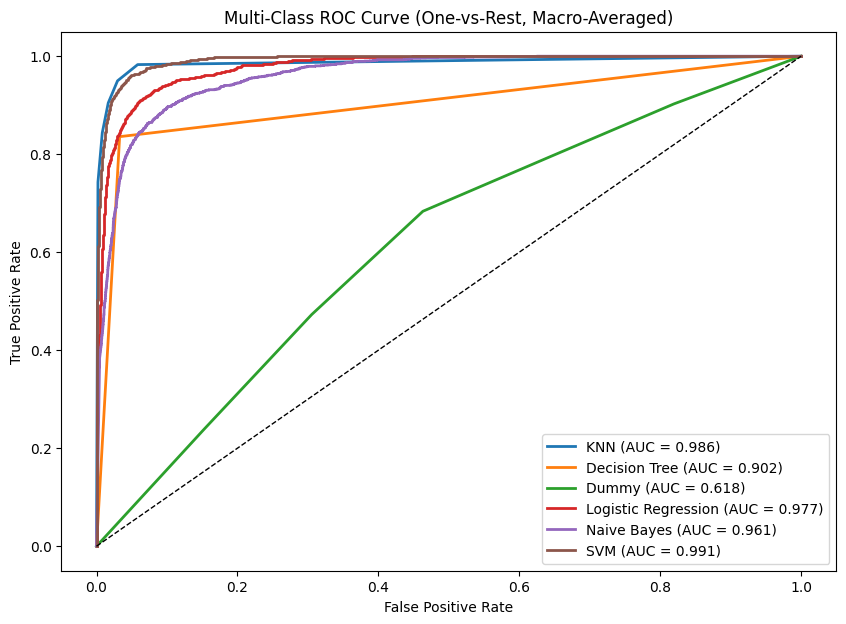

In [7]:
roc_curves(models)

In [8]:
def roc_results(model_list):
    roc_results = []
    classes = np.unique(y_encoded)
    y_test_bin = label_binarize(y_test, classes=classes)
    for name, model in model_list.items():
        y_score = model.predict_proba(X_test) if hasattr(model, "predict_proba") else model.decision_function(X_test)
        auc_value = roc_auc = auc(*roc_curve(y_test_bin.ravel(), y_score.ravel())[:2])
        roc_results.append([name, auc_value])

    roc_df = pd.DataFrame(roc_results, columns=["Model", "Macro-AUC"])
    roc_df.sort_values(by="Macro-AUC", ascending=False)
    return roc_df

In [9]:
roc_df = roc_results(models)
roc_df

,Model,Macro-AUC
0,KNN,0.986402
1,Decision Tree,0.901502
2,Dummy,0.618125
3,Logistic Regression,0.977496
4,Naive Bayes,0.960560
5,SVM,0.991327


### Interpretation

**Highest Macro-Averaged AUC**  

→ **Support Vector Machine (SVM)** with **AUC = 0.991**  
This model demonstrates superior class separability and consistent performance across decision thresholds, indicating strong overall robustness.  


**Model with AUC < 0.5**  

→ None of the evaluated models recorded an AUC below 0.5.  
Conceptually, an **AUC < 0.5** implies the model performs worse than random chance — ranking negative instances higher than positive ones.  
Such cases typically arise due to:  

- Inverted or miscalibrated probability predictions,  
- Presence of label noise or incorrect class labeling, or  
- The model learning incorrect patterns caused by bias, class imbalance, or preprocessing errors.


## Part C : Precision-Recall Curve (PRC) Analysis



###  Why Precision–Recall Curve (PRC) is Better for Imbalanced Classes

ROC can be misleading under class imbalance because it incorporates true negatives; when negatives dominate, the false positive rate

$$
\text{FPR} \;=\; \frac{FP}{FP + TN}
$$

can be very small even for poor models, inflating ROC performance.

PRC focuses on the positive class using:

$$
\text{Precision} \;=\; \frac{TP}{TP + FP}, \qquad
\text{Recall} \;=\; \frac{TP}{TP + FN}.
$$

Because PRC ignores true negatives, it more directly measures how well the model retrieves positive instances while maintaining prediction quality. This makes PRC **more informative** for imbalanced problems (and still useful for moderate imbalance, as it reveals trade-offs between precision and recall across thresholds).


### Plotting PRC curves

In [10]:
def prc_curves(model_list):
    plt.figure(figsize=(10, 7))
    
    classes = np.unique(y_encoded)
    y_test_bin = label_binarize(y_test, classes=classes)

    prc_results = []

    for name, model in model_list.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)

        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
        ap = average_precision_score(y_test_bin, y_score, average="macro")
        prc_results.append([name, ap])
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {ap:.3f})")

    plt.title("Multi-Class Precision–Recall Curve (Macro-Averaged)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()



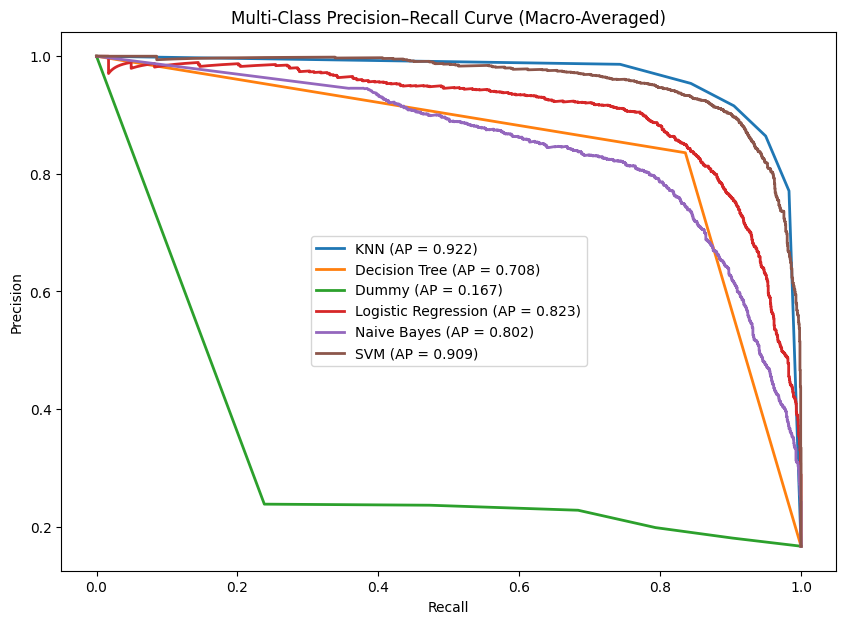

In [11]:
prc_curves(models)

In [12]:
def prc_results(model_list):
    prc_results = []
    classes = np.unique(y_encoded)
    y_test_bin = label_binarize(y_test, classes=classes)

    for name, model in model_list.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)

        ap_value = average_precision_score(y_test_bin, y_score, average="macro")
        prc_results.append([name, ap_value])
    prc_df = pd.DataFrame(prc_results, columns=["Model", "Average Precision"])
    prc_df = prc_df.sort_values(by="Average Precision", ascending=False).reset_index(drop=True)

    return prc_df

In [13]:
prc_df = prc_results(models)
prc_df

,Model,Average Precision
0,KNN,0.922489
1,SVM,0.909478
2,Logistic Regression,0.822773
3,Naive Bayes,0.802210
4,Decision Tree,0.708009
5,Dummy,0.166667


### PRC Interpretation

**Model with Highest Average Precision**

→ **K-Nearest Neighbors (KNN)** achieved the highest **AP = 0.922**, demonstrating that it maintains strong precision across a wide range of recall values.  
This indicates that KNN effectively identifies true positives while minimizing false positives — showcasing robust discriminative capability across all classes.


**Behavior of the Worst Model (Dummy Classifier)**

- The **Dummy Classifier (AP = 0.167)** performs nearly at random levels.  
- Its PR curve declines sharply as recall increases because:

  - When the model attempts to capture more positives (higher recall), it simultaneously misclassifies many negatives as positives.  
  - As these incorrect predictions accumulate, **precision drops steeply**, leading to a near-vertical fall in the PR curve.

- This behavior highlights a **high false-positive rate** and the **absence of any meaningful learned decision boundary**.


## Part D : Comparative Analysis

In [14]:
for df in [baseline_df, roc_df, prc_df]:
    df["Model"] = df["Model"].str.strip().str.lower().str.replace(" ", "")

final_df = (
    baseline_df
    .merge(roc_df, on="Model", how="outer")
    .merge(prc_df, on="Model", how="outer")
)

final_df = final_df.sort_values(
    by=["Macro-AUC", "Average Precision", "Weighted F1"],
    ascending=False
).reset_index(drop=True)

display(final_df)


,Model,Accuracy,Weighted F1,Macro-AUC,Average Precision
0,svm,0.897462,0.895996,0.991327,0.909478
1,knn,0.910927,0.909984,0.986402,0.922489
2,logisticregression,0.838426,0.811908,0.977496,0.822773
3,naivebayes,0.793371,0.800111,0.960560,0.802210
4,decisiontree,0.835836,0.836570,0.901502,0.708009
5,dummy,0.238219,0.091661,0.618125,0.166667


### Observation

- The **top performers — KNN and SVM —** lead across all metrics.  
- **KNN** slightly outperforms **SVM** in **F1-score** and **Average Precision (PRC)**, showing better precision–recall balance.  
- **SVM** edges ahead in **ROC-AUC**, indicating stronger overall class separability.  
- **Logistic Regression** performs decently but trails behind KNN/SVM.  
- **Decision Tree** and **Naive Bayes** lag due to overfitting or simplifying assumptions.  
- **Dummy Classifier** serves as the random baseline.


### Do the Rankings Align?

**Largely yes, with minor trade-offs:**

- **ROC-AUC vs PRC-AP:**  
  Both **SVM** and **KNN** achieve ROC-AUC > 0.98, confirming excellent separation.  
  However, **PRC-AP** better captures performance on the **positive class**, making it more revealing in imbalanced data.

- Models like **Decision Tree** may retain a good **ROC-AUC (0.90)** but a lower **PRC-AP (0.71)**, showing poor precision at higher recall levels.


### Takeaway

- **ROC-AUC** measures **probability ranking quality**.  
- **PRC-AP** reflects the **accuracy of positive predictions**.  
- A model can separate classes well (**high ROC-AUC**) yet generate many false positives, reducing its **PRC-AP**.


## Further Experimentation

### Training Models

In [15]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

class FlippedLogisticRegression(LogisticRegression):
    """Custom logistic regression that returns inverted probabilities."""
    def predict_proba(self, X):
        base_probs = super().predict_proba(X)
        return 1 - base_probs  

extra_models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "InvertedDummy": DummyClassifier(strategy='uniform', random_state=42),
    "FlippedLogReg": FlippedLogisticRegression(max_iter=1000),
}

for name, model in extra_models.items():
    model.fit(X_train, y_train)

### Baseline Evaluation

In [17]:
results = []
for name, model in extra_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append([name, acc, f1])

baseline_df2 = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1"])
display(baseline_df2.sort_values(by="Accuracy", ascending=False))

,Model,Accuracy,Weighted F1
0,RandomForest,0.917141,0.914235
1,XGBoost,0.917141,0.915578
3,FlippedLogReg,0.858622,0.851291
2,InvertedDummy,0.170378,0.175786


### ROC curve

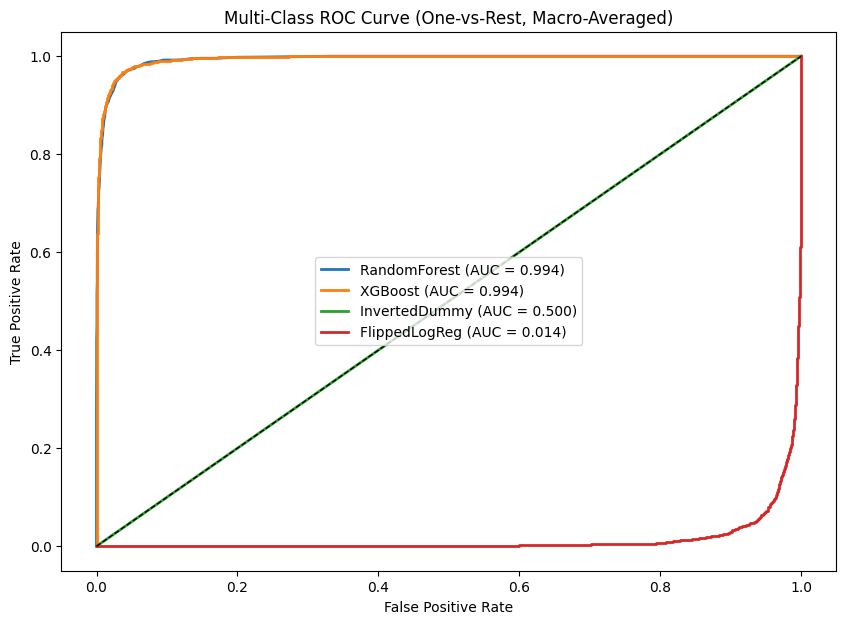

In [18]:
roc_curves(extra_models)

In [19]:
roc_df2 = roc_results(extra_models)
roc_df2

,Model,Macro-AUC
0,RandomForest,0.993675
1,XGBoost,0.994392
2,InvertedDummy,0.500000
3,FlippedLogReg,0.014092


### PRC Curve

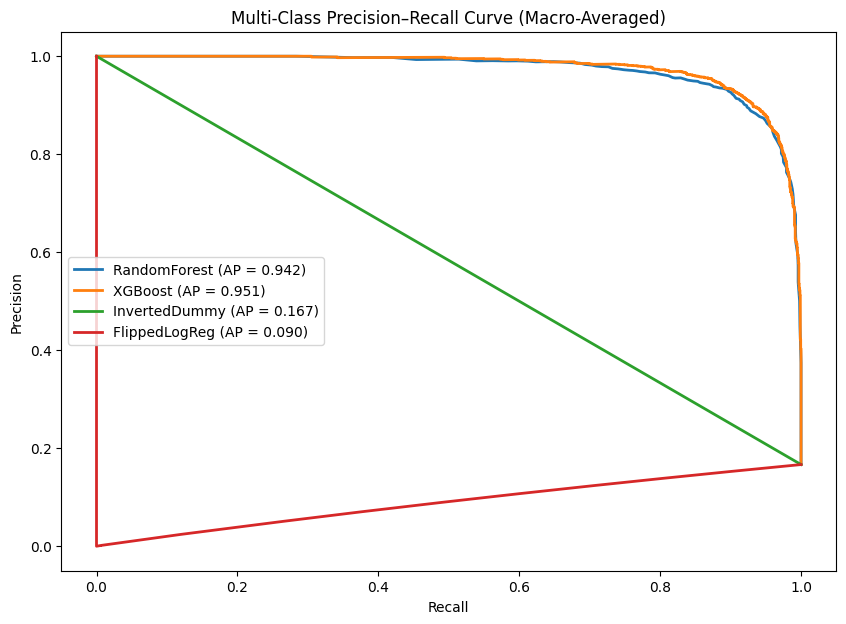

In [20]:
prc_curves(extra_models)

In [21]:
prc_df2 = prc_results(extra_models)
prc_df2

,Model,Average Precision
0,XGBoost,0.950879
1,RandomForest,0.942113
2,InvertedDummy,0.166667
3,FlippedLogReg,0.090171


### Final Comparison

In [22]:
for df in [baseline_df2, roc_df2, prc_df2]:
    df["Model"] = df["Model"].str.strip().str.lower().str.replace(" ", "")

final_df2 = (
    baseline_df2
    .merge(roc_df2, on="Model", how="outer")
    .merge(prc_df2, on="Model", how="outer")
)

final_df2 = final_df2.sort_values(
    by=["Macro-AUC", "Average Precision", "Weighted F1"],
    ascending=False
).reset_index(drop=True)

display(final_df2)

,Model,Accuracy,Weighted F1,Macro-AUC,Average Precision
0,xgboost,0.917141,0.915578,0.994392,0.950879
1,randomforest,0.917141,0.914235,0.993675,0.942113
2,inverteddummy,0.170378,0.175786,0.500000,0.166667
3,flippedlogreg,0.858622,0.851291,0.014092,0.090171


### 1. **Results Summary**

Among all models tested, **XGBoost** and **Random Forest** delivered top-tier performance, both achieving around **91.7% accuracy**, **F1-scores near 0.91**, and **ROC-AUC ≈ 0.994**. Their **Average Precision (PRC-AP)** scores were also very high (>0.94), confirming excellent balance between precision and recall.  
The **Inverted Dummy** model performed at random levels (AUC ≈ 0.50, AP ≈ 0.17), while the **Flipped Logistic Regression** showed an unusual case with **AUC ≈ 0.01** despite decent accuracy — a clear example of inverted probability rankings.


### 2. **ROC & PRC Interpretation**

#### High-Performing Models – Random Forest and XGBoost  
Both ensemble models achieve near-perfect class separation:
- **ROC-AUC ≈ 0.994** reflects exceptional discriminative ability.  
- **PRC-AP > 0.94** shows consistent precision even at higher recall levels.  
- Accuracy and F1 around 0.91 indicate reliable and balanced multi-class performance.

Between the two, **XGBoost** slightly outperforms Random Forest because:
- It learns iteratively from previous errors, achieving a better **bias–variance trade-off**.  
- It incorporates **L1 and L2 regularization**, reducing overfitting.  
- Its probability calibration is generally smoother and more stable.

#### Poor Models – Inverted Dummy & Flipped Logistic Regression  
- The **Inverted Dummy** behaves as a random predictor with AUC around 0.50 and PRC near 0.17, showing no meaningful learning.  
- The **Flipped Logistic Regression**, although accurate in classification labels, inverts its probability ranking — producing an **AUC < 0.5** (around 0.01) and very low precision–recall (AP ≈ 0.09). This demonstrates what happens when a model’s output scores are reversed, ranking negatives above positives.


### 3. **Synthesis & Comparison**

Across all metrics:
- **XGBoost** consistently ranks first, followed closely by **Random Forest**.  
- The ensemble methods clearly dominate traditional models in both ranking ability (ROC-AUC) and positive-class precision (PRC-AP).  
- **Flipped Logistic Regression** and **Inverted Dummy** occupy the lowest tiers — one due to score inversion, the other due to random guessing.

Overall ranking:  
**XGBoost > Random Forest ≫ Flipped Logistic Regression ≫ Inverted Dummy**


### 4. **Recommendation**

**Recommended Model → XGBoost**

- Delivers the **highest Weighted F1 (0.916)** and **PRC-AP (0.951)**, while matching Random Forest’s outstanding AUC (0.994).  
- Provides better generalization and more reliable probability estimates due to boosting and regularization.  
- The poor-performing models help validate the evaluation setup — **Flipped Logistic Regression** exemplifies an AUC below 0.5 scenario, and **Inverted Dummy** represents a random baseline.

**Final Verdict:**  
 **XGBoost** stands out as the most robust, consistent, and generalizable model across all performance metrics.
